# Part A: Classification Problem

This project aims at building neural networks to classify the Cardiotocography dataset containing measurements of fetal heart rate (FHR) and uterine contraction (UC) features on 2126 cardiotocograms classified by expert obstetricians \[1\]. The dataset can be obtained from: https://archive.ics.uci.edu/ml/datasets/Cardiotocography.

The cardiotocograms were classified by three expert obstetricians and a consensus classification label with respect to a morphologic pattern and to a fetal state (N: Normal; S: Suspect; P: Pathologic) was assigned to each of them. The aim is to predict the N, S and P class labels in the test dataset after training the neural network on the training dataset.

Read the data from the file: ctg_data_cleaned.csv. Each data sample is a row of 23 values: 21 input attributes and 2 class labels (use the NSP label with values 1, 2 and 3 and ignore the other). First, divide the dataset in 70:30 ratio for training and testing. Use 5-fold cross-validation on the training dataset for selecting the optimal model, and test it on the testing data.

\[1\] Ayres de Campos et al. (2000) SisPorto 2.0 A Program for Automated Analysis of
Cardiotocograms. J Matern Fetal Med 5:311-318.

In [1]:
# import relevant libraries
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import time

In [2]:
# configurations
seed = 0  # for reproducible results when randomness is introduced

In [3]:
# load data
dataframe = pd.read_csv('data/ctg_data_cleaned.csv')
dataframe.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,...,126,2,0,120,137,121,73,1,9,2
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,...,198,6,1,141,136,140,12,0,6,1
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,...,198,5,1,141,135,138,13,0,6,1
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,...,170,11,0,137,134,137,13,1,6,1
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,...,170,9,0,137,136,138,11,1,2,1


In [4]:
# show basic information of data
dataframe.describe()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,...,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,4.509878,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,...,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,3.026883,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,2.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,4.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,...,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,7.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,...,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,10.000000,3.000000


In [5]:
# drop other class label since we are using NSP label
dataframe = dataframe.drop(columns='CLASS')
dataframe.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,...,62,126,2,0,120,137,121,73,1,2
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,...,68,198,6,1,141,136,140,12,0,1
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,...,68,198,5,1,141,135,138,13,0,1
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,...,53,170,11,0,137,134,137,13,1,1
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,...,53,170,9,0,137,136,138,11,1,1


In [6]:
labels = dataframe['NSP']
features = dataframe.drop(columns='NSP')

del dataframe

In [7]:
labels.head()

0    2
1    1
2    1
3    1
4    1
Name: NSP, dtype: int64

In [8]:
features.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,...,64,62,126,2,0,120,137,121,73,1
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,...,130,68,198,6,1,141,136,140,12,0
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,...,130,68,198,5,1,141,135,138,13,0
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,...,117,53,170,11,0,137,134,137,13,1
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,...,117,53,170,9,0,137,136,138,11,1


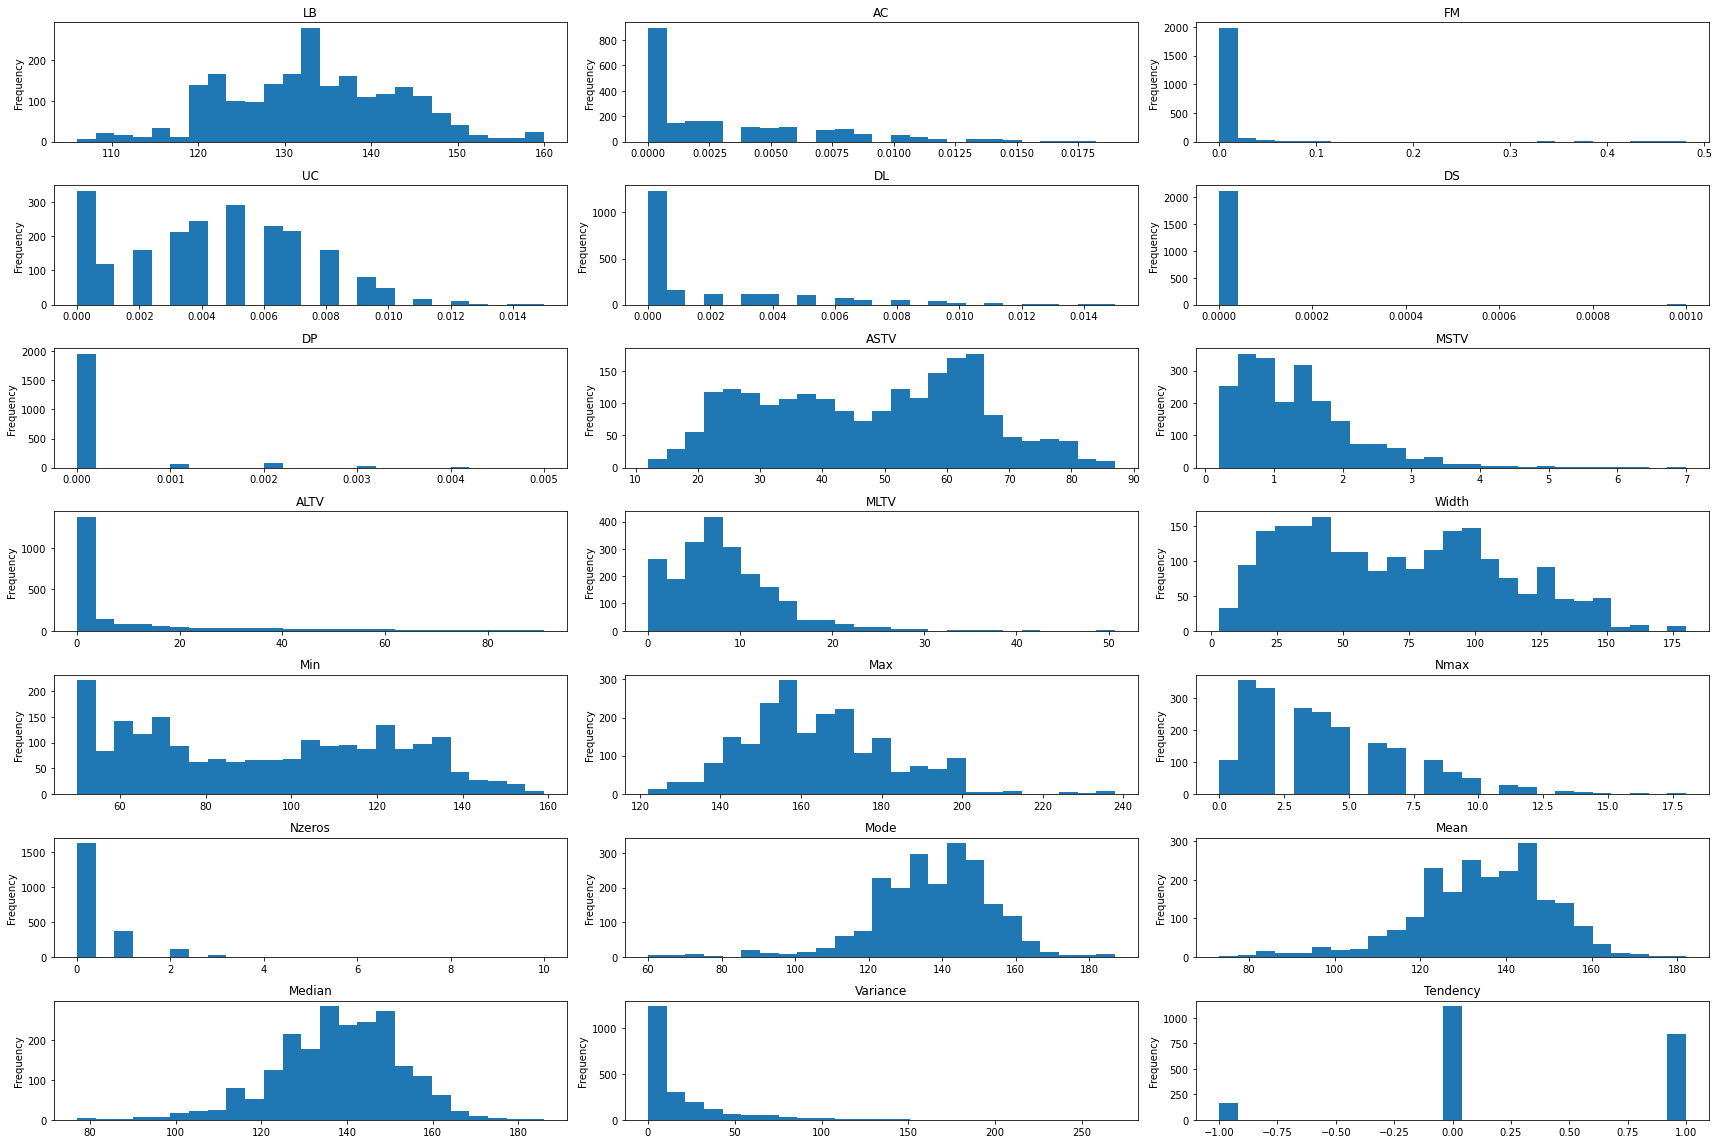

In [9]:
# show distribution for each feature
figure, axes = plt.subplots(nrows=7, ncols=3, figsize=(24, 16))

for index, column in enumerate(features.columns):
    feature = features[column]

    row_num = index // 3
    col_num = index % 3

    feature.plot.hist(bins=25, ax=axes[row_num, col_num])
    axes[row_num, col_num].set_title(column)

figure.tight_layout()

plt.savefig('output/a.png')

del figure

It seems that some of the features follow normal distribution, so let's normalise the data by subtracting mean and dividing by standard deviation to get standard score.

In [10]:
scaler = StandardScaler()
features = scaler.fit_transform(features)
features = pd.DataFrame(features)

del scaler

In [11]:
# let labels start from 0 to correspond to list index
labels -= 1
print(labels.unique())

[1 0 2]


In [12]:
# divide the dataset in 70:30 ratio for training and testing
train_features, test_features, train_labels, test_labels = train_test_split(
    features,
    labels,
    test_size=0.3,
    random_state=seed,
)

In [13]:
train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
994,-0.437449,0.212626,-0.20321,-1.142949,-0.638438,-0.057476,-0.268754,-1.162976,-0.150373,-0.480991,...,-0.268212,0.149578,-0.335865,-0.362263,-0.458444,-0.271839,-0.103306,-0.282808,-0.511138,-0.524526
1618,0.883886,-0.046128,0.86849,-0.803434,1.388924,-0.057476,1.426711,1.105948,2.227792,-0.535361,...,1.092629,-0.899376,0.890448,0.994270,-0.458444,0.216638,-1.514474,0.616025,2.457366,1.112980
177,-1.453861,1.247640,-0.20321,0.215111,-0.300544,-0.057476,-0.268754,-0.988443,0.529103,-0.535361,...,1.503448,-0.831702,1.893794,1.672537,-0.458444,-0.332898,-0.167450,-0.213667,0.041142,-0.524526
519,-0.742373,1.247640,0.65415,0.215111,-0.638438,-0.057476,-0.268754,-0.290313,0.189365,-0.535361,...,1.965620,-1.440771,1.893794,1.672537,-0.458444,-0.271839,0.089126,-0.282808,-0.200481,-0.524526
745,0.883886,-0.563635,-0.20321,0.215111,3.416285,-0.057476,-0.268754,-1.395686,2.567530,-0.535361,...,1.888592,-1.474609,1.670828,2.689937,0.958201,0.338757,-0.488170,-0.213667,1.836051,-0.524526


1. Design a feedforward neural network which consists of an input layer, one hidden layer of 10 neurons with ReLU activation function, and an output softmax layer. Assume a learning rate α = 0.01, L<sub>2</sub> regularization with weight decay parameter β = 10<sup>-6</sup> , and batch size = 32. Use appropriate scaling of input features.

In [14]:
# input layer params
num_features = len(features.columns)

# hidden layer params
num_hidden_neurons = 10
hidden_activation = 'relu'
weight_decay_parameter = 10**-6

# output layer params
num_classes = labels.nunique()  # 3: N, S, P
output_activation = 'softmax'

# training params
learning_rate = 0.01
batch_size = 32
num_epochs = 1000  # arbitrary number that is large enough (hopefully)

del features
del labels

In [15]:
def get_3_layer_nn(num_neurons: int, decay_param: float) -> tf.keras.Sequential:
    '''
    Generates a 3-layer fully-connected neural network.
        layer 1 - input layer
        layer 2 - hidden layer
        layer 3 - output layer (softmax)

    :params:
    - num_neurons (int): number of neurons in the hidden layer
    - decay_param (float): weight decay parameter for L_2 loss

    :return:
    - (tf.keras.Sequential)
    '''
    input_layer = tf.keras.layers.InputLayer(
        input_shape=num_features,
    )

    hidden_layer = tf.keras.layers.Dense(
        num_neurons,
        activation=hidden_activation,
        kernel_regularizer=tf.keras.regularizers.l2(l=decay_param),
    )

    output_layer = tf.keras.layers.Dense(
        num_classes,
        activation=output_activation,
    )

    model = tf.keras.Sequential([
        input_layer,
        hidden_layer,
        output_layer,
    ])

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
        metrics=['accuracy'],
    )

    return model

In [16]:
# check model
model = get_3_layer_nn(num_hidden_neurons, weight_decay_parameter)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                220       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 253
Trainable params: 253
Non-trainable params: 0
_________________________________________________________________


a) Use the training dataset to train the model and plot accuracies on training and testing data against training epochs.

In [17]:
# train model

tf.random.set_seed(seed)  # since shuffle=True

train_history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    verbose=0,  # not showing training details
    validation_data=(test_features, test_labels),
    shuffle=True,
)

results = model.evaluate(
    test_features,
    test_labels,
    batch_size=batch_size,
    return_dict=True,
)

loss = results['loss']
accuracy = results['accuracy']
print(f'test loss: {loss:.2f}, test accuracy: {accuracy:.2f}')

del model

20/20 [==============================] - 0s 1ms/step - loss: 0.6579 - accuracy: 0.8950
test loss: 0.66, test accuracy: 0.89


In [18]:
history = train_history.history
print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


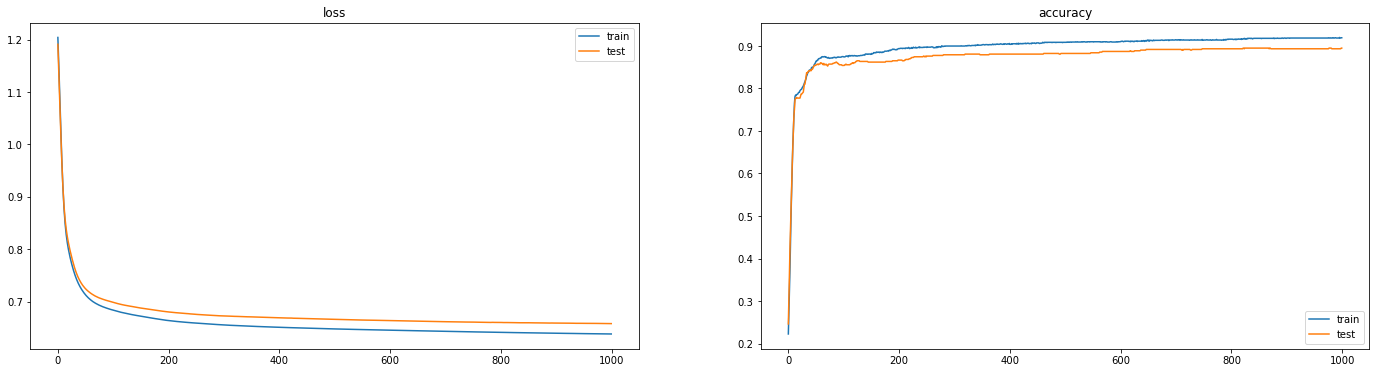

In [19]:
# plot curves

_, (loss_axis, accuracy_axis) = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

loss_axis.set_title('loss')
loss_axis.plot(range(num_epochs), history['loss'], label='train')
loss_axis.plot(range(num_epochs), history['val_loss'], label='test')
loss_axis.legend()

accuracy_axis.set_title('accuracy')
accuracy_axis.plot(range(num_epochs), history['accuracy'], label='train')
accuracy_axis.plot(range(num_epochs), history['val_accuracy'], label='test')
accuracy_axis.legend()

plt.savefig('output/a_1a.png')

del loss_axis
del accuracy_axis

b) State the approximate number of epochs where the test error begin to converge.

In [20]:
test_loss_history = history['val_loss']
epsilon = 10**-4  # arbitrary small number

convergence_num_epochs = 1

for index in reversed(range(1, num_epochs)):
    if test_loss_history[index - 1] - test_loss_history[index] > epsilon:
        convergence_num_epochs = index
        break

print(f'number of epochs till convergence: {convergence_num_epochs}')

del history

number of epochs till convergence: 977


In [21]:
# use 5-fold cross-validation for selecting optimal model
num_splits = 5
kfold = KFold(n_splits=num_splits, shuffle=True, random_state=seed)

2. Find the optimal batch size by training the neural network and evaluating the performances for different batch sizes.

Note: use this optimal batch size for the rest of the experiments.

a) Plot cross-validation accuracies against the number of epochs for different batch sizes. Limit search space to batch sizes {4,8,16,32,64}. Plot the time taken to train the network for one epoch against different batch sizes

In [22]:
# training params

batch_sizes = [4, 8, 16, 32, 64]

In [23]:
batch_sizes_info = {batch_size: {} for batch_size in batch_sizes}

for batch_size in batch_sizes:
    print(f'trying out batch size of {batch_size}')
    time_taken = 0

    best_fold = 0
    best_results = {'loss': 1, 'accuracy': 0}
    best_history = None

    # 5-fold cross validation using training set
    splits = kfold.split(train_features, train_labels)
    for fold_index, (train_indices, val_indices) in enumerate(splits):
        print(f'working on fold {fold_index}')
        model = get_3_layer_nn(num_hidden_neurons, weight_decay_parameter)

        train_features_subset = train_features.iloc[train_indices]
        train_labels_subset = train_labels.iloc[train_indices]

        val_features = train_features.iloc[val_indices]
        val_labels = train_labels.iloc[val_indices]

        start_time = time.perf_counter()
        train_history = model.fit(
            x=train_features_subset,
            y=train_labels_subset,
            batch_size=batch_size,
            epochs=num_epochs,
            verbose=0,  # not showing training details
            validation_data=(val_features, val_labels),
            shuffle=True,
        )
        time_taken += (time.perf_counter() - start_time)

        results = model.evaluate(
            test_features,
            test_labels,
            batch_size=batch_size,
            return_dict=True,
        )

        if results['accuracy'] > best_results['accuracy']:
            best_fold = fold_index
            best_model = model
            best_results = results
            best_history = train_history

    loss = best_results['loss']
    accuracy = best_results['accuracy']
    print(f'best fold: {best_fold}, loss: {loss:.2f}, accuracy: {accuracy:.2f}')
    
    batch_sizes_info[batch_size]['epoch_time_taken'] = time_taken / (num_splits * num_epochs)
    batch_sizes_info[batch_size]['model'] = best_model
    batch_sizes_info[batch_size]['results'] = results
    batch_sizes_info[batch_size]['history'] = best_history

trying out batch size of 4
working on fold 0
160/160 [==============================] - 0s 1ms/step - loss: 0.6602 - accuracy: 0.8887
working on fold 1
160/160 [==============================] - 0s 1ms/step - loss: 0.6538 - accuracy: 0.8934
working on fold 2
160/160 [==============================] - 0s 1ms/step - loss: 0.6464 - accuracy: 0.9044
working on fold 3
160/160 [==============================] - 0s 1ms/step - loss: 0.6714 - accuracy: 0.8746
working on fold 4
160/160 [==============================] - 0s 1ms/step - loss: 0.6373 - accuracy: 0.9138
best fold: 4, loss: 0.64, accuracy: 0.91
trying out batch size of 8
working on fold 0
80/80 [==============================] - 0s 1ms/step - loss: 0.6530 - accuracy: 0.8966
working on fold 1
80/80 [==============================] - 0s 1ms/step - loss: 0.6649 - accuracy: 0.8824
working on fold 2
80/80 [==============================] - 0s 1ms/step - loss: 0.6534 - accuracy: 0.8950
working on fold 3
80/80 [==============================

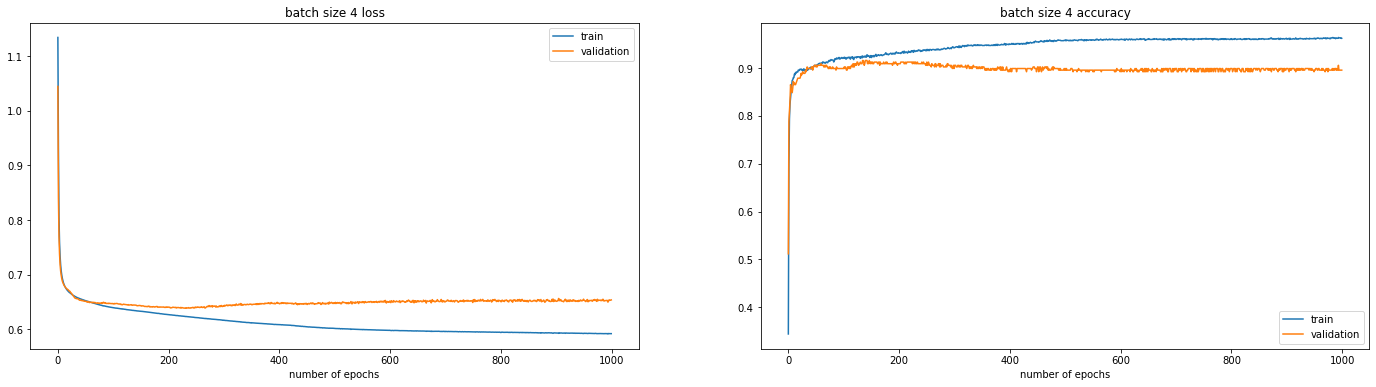

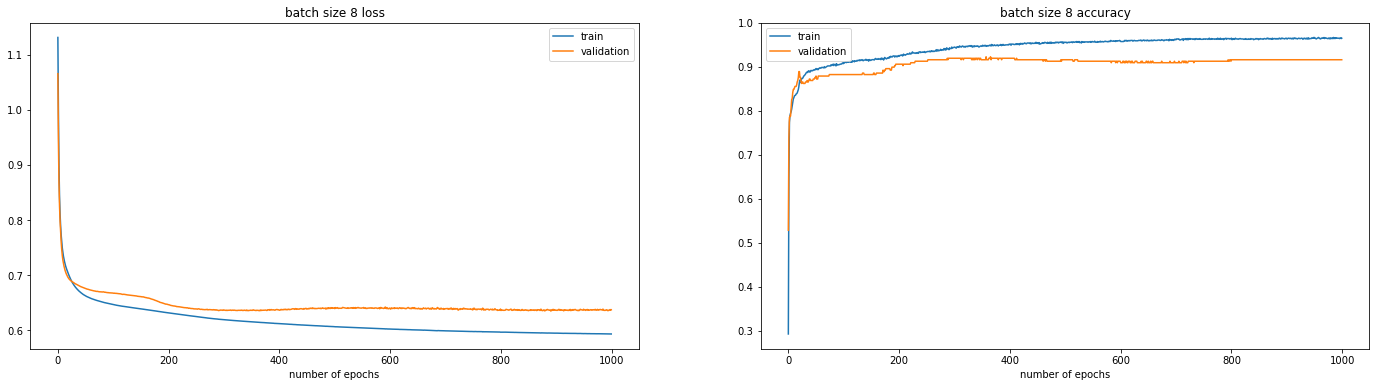

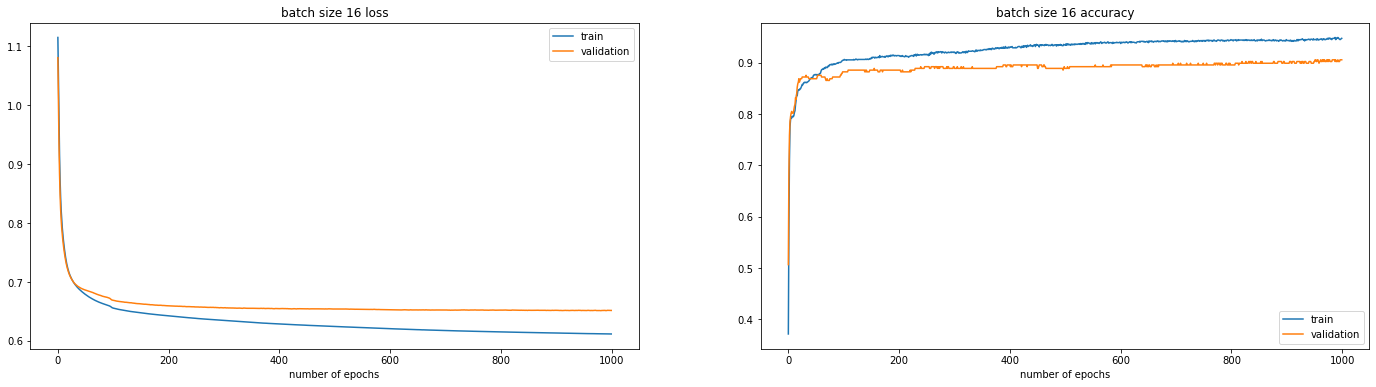

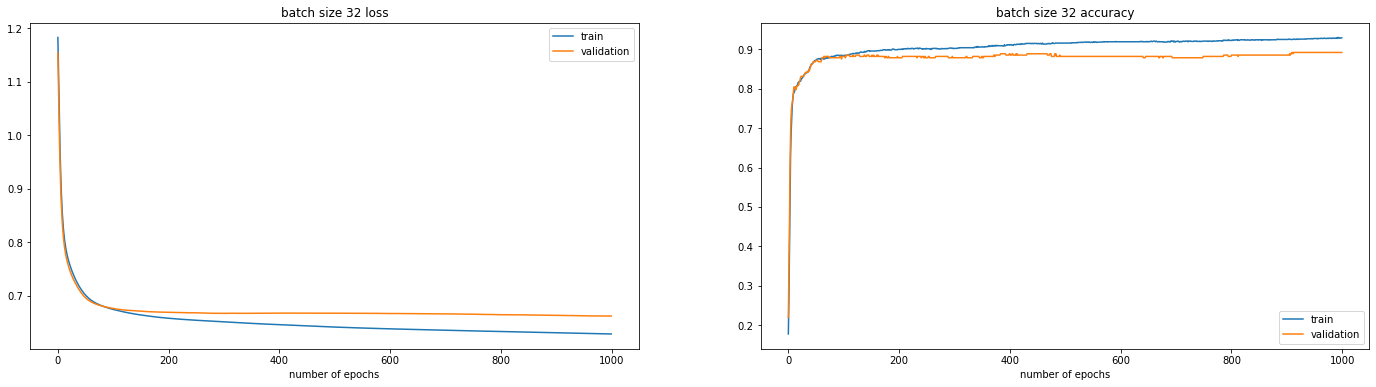

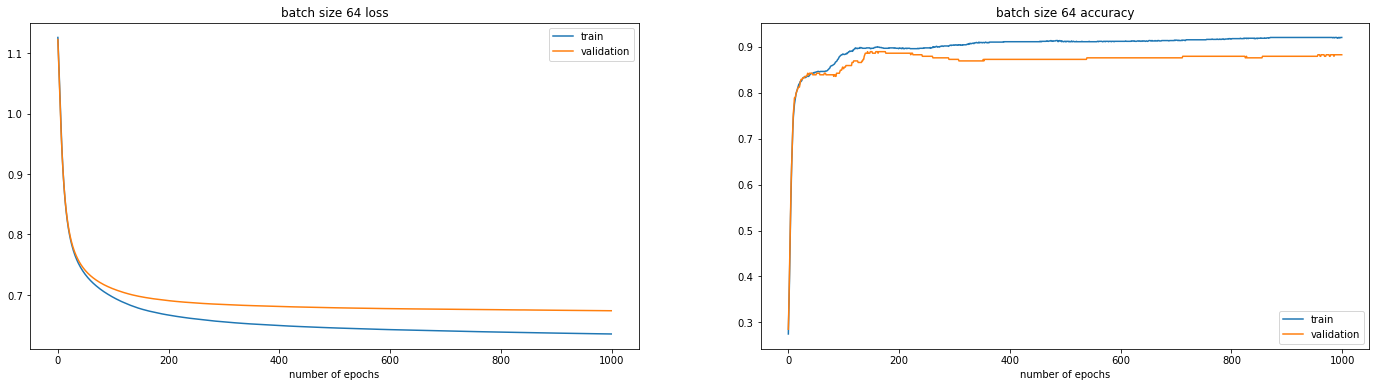

In [24]:
# plot loss and accuracy curves
for batch_size, info in batch_sizes_info.items():   
    history = info['history'].history
    _, (loss_axis, accuracy_axis) = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

    loss_axis.set_title(f'batch size {batch_size} loss')
    
    loss_axis.plot(range(num_epochs), history['loss'], label='train')
    loss_axis.plot(range(num_epochs), history['val_loss'], label='validation')
    
    loss_axis.legend()
    loss_axis.set_xlabel('number of epochs')

    accuracy_axis.set_title(f'batch size {batch_size} accuracy')
    
    accuracy_axis.plot(range(num_epochs), history['accuracy'], label='train')
    accuracy_axis.plot(range(num_epochs), history['val_accuracy'], label='validation')
    
    accuracy_axis.legend()
    accuracy_axis.set_xlabel('number of epochs')

plt.savefig('output/a_2a1.png')
print()

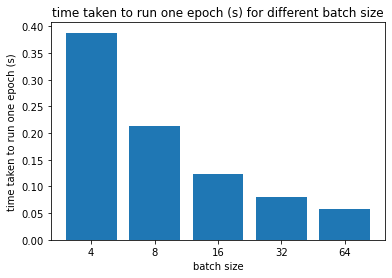

In [25]:
# plot time taken for one epoch for each batch size
batch_sizes = []
epoch_time_taken_list = []

for batch_size, info in batch_sizes_info.items():
    batch_sizes.append(batch_size)
    epoch_time_taken_list.append(info['epoch_time_taken'])
    
batch_size_position = [index for index in range(len(batch_sizes))]

plt.bar(batch_size_position, epoch_time_taken_list)
plt.xticks(batch_size_position, batch_sizes)

plt.xlabel('batch size')
plt.ylabel('time taken to run one epoch (s)')

plt.title('time taken to run one epoch (s) for different batch size')
plt.savefig('output/a_2a2.png')
print()

In [26]:
del batch_sizes_info

b) Select the optimal batch size and state reasons for your selection.

I would go with batch size of 64. It requires a least amount of time for one epoch of training. The reduction of accuracy is only slightly lower. Also, the learning rate is supposed to be adjusted with batch size, but it was not, leading to lower accuracy for larger batch size. [example](https://stackoverflow.com/a/53046624/9171260)

c) Plot the train and test accuracies against epochs for the optimal batch size.

In [27]:
optimal_batch_size = 64

In [28]:
# train model on whole training set
model = get_3_layer_nn(num_hidden_neurons, weight_decay_parameter)

train_history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=optimal_batch_size,
    epochs=num_epochs,
    verbose=0,  # not showing training details
    validation_data=(test_features, test_labels),
    shuffle=True,
)

results = model.evaluate(
    test_features,
    test_labels,
    batch_size=optimal_batch_size,
    return_dict=True,
)

loss = results['loss']
accuracy = results['accuracy']
print(f'test loss: {loss:.2f}, test accuracy: {accuracy:.2f}')

del model

10/10 [==============================] - 0s 1ms/step - loss: 0.6711 - accuracy: 0.8809
test loss: 0.67, test accuracy: 0.88


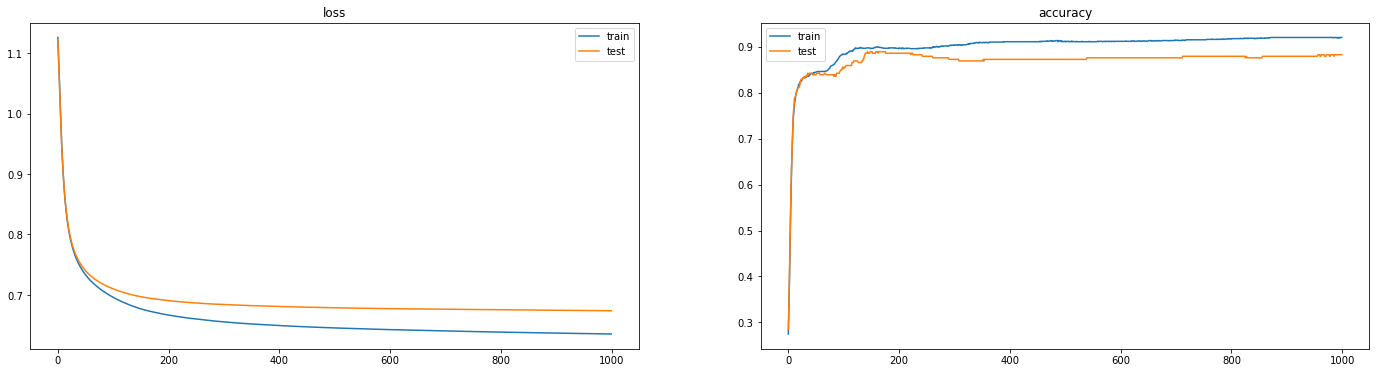

In [29]:
# plot curves
_, (loss_axis, accuracy_axis) = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

loss_axis.set_title('loss')
loss_axis.plot(range(num_epochs), history['loss'], label='train')
loss_axis.plot(range(num_epochs), history['val_loss'], label='test')
loss_axis.legend()

accuracy_axis.set_title('accuracy')
accuracy_axis.plot(range(num_epochs), history['accuracy'], label='train')
accuracy_axis.plot(range(num_epochs), history['val_accuracy'], label='test')
accuracy_axis.legend()

plt.savefig('output/a_2c.png')

del loss_axis
del accuracy_axis

3. Find the optimal number of hidden neurons for the 3-layer network designed in part (2).

a) Plot the cross-validation accuracies against the number of epochs for different
number of hidden-layer neurons. Limit the search space of number of neurons to
{5,10,15,20,25}.

In [30]:
# training params

num_hidden_neurons_list = [5, 10, 15, 20, 25]

In [31]:
num_neurons_info = {num_neurons: {} for num_neurons in num_hidden_neurons_list}

for num_hidden_neurons in num_hidden_neurons_list:
    print(f'trying out {num_hidden_neurons} neurons in hidden layer')

    best_fold = 0
    best_results = {'loss': 1, 'accuracy': 0}
    best_history = None

    # 5-fold cross validation using training set
    splits = kfold.split(train_features, train_labels)
    for fold_index, (train_indices, val_indices) in enumerate(splits):
        print(f'working on fold {fold_index}')
        model = get_3_layer_nn(num_hidden_neurons, weight_decay_parameter)

        train_features_subset = train_features.iloc[train_indices]
        train_labels_subset = train_labels.iloc[train_indices]

        val_features = train_features.iloc[val_indices]
        val_labels = train_labels.iloc[val_indices]

        train_history = model.fit(
            x=train_features_subset,
            y=train_labels_subset,
            batch_size=optimal_batch_size,
            epochs=num_epochs,
            verbose=0,  # not showing training details
            validation_data=(val_features, val_labels),
            shuffle=True,
        )

        results = model.evaluate(
            test_features,
            test_labels,
            batch_size=optimal_batch_size,
            return_dict=True,
        )

        if results['accuracy'] > best_results['accuracy']:
            best_fold = fold_index
            best_model = model
            best_results = results
            best_history = train_history

    loss = best_results['loss']
    accuracy = best_results['accuracy']
    print(f'best fold: {best_fold}, loss: {loss:.2f}, accuracy: {accuracy:.2f}')
    
    num_neurons_info[num_hidden_neurons]['model'] = best_model
    num_neurons_info[num_hidden_neurons]['results'] = results
    num_neurons_info[num_hidden_neurons]['history'] = best_history

trying out 5 neurons in hidden layer
working on fold 0
10/10 [==============================] - 0s 1ms/step - loss: 0.6998 - accuracy: 0.8511
working on fold 1
10/10 [==============================] - 0s 1ms/step - loss: 0.7128 - accuracy: 0.8229
working on fold 2
10/10 [==============================] - 0s 1ms/step - loss: 0.6603 - accuracy: 0.8934
working on fold 3
10/10 [==============================] - 0s 1ms/step - loss: 0.6841 - accuracy: 0.8652
working on fold 4
10/10 [==============================] - 0s 1ms/step - loss: 0.6610 - accuracy: 0.8918
best fold: 2, loss: 0.66, accuracy: 0.89
trying out 10 neurons in hidden layer
working on fold 0
10/10 [==============================] - 0s 1ms/step - loss: 0.7050 - accuracy: 0.8542
working on fold 1
10/10 [==============================] - 0s 1ms/step - loss: 0.6585 - accuracy: 0.8950
working on fold 2
10/10 [==============================] - 0s 1ms/step - loss: 0.6788 - accuracy: 0.8762
working on fold 3
10/10 [===================

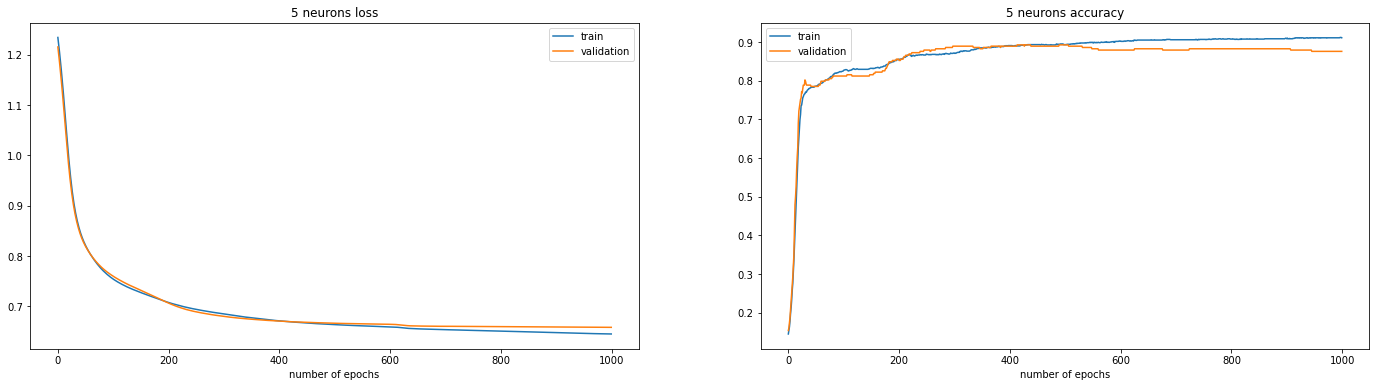

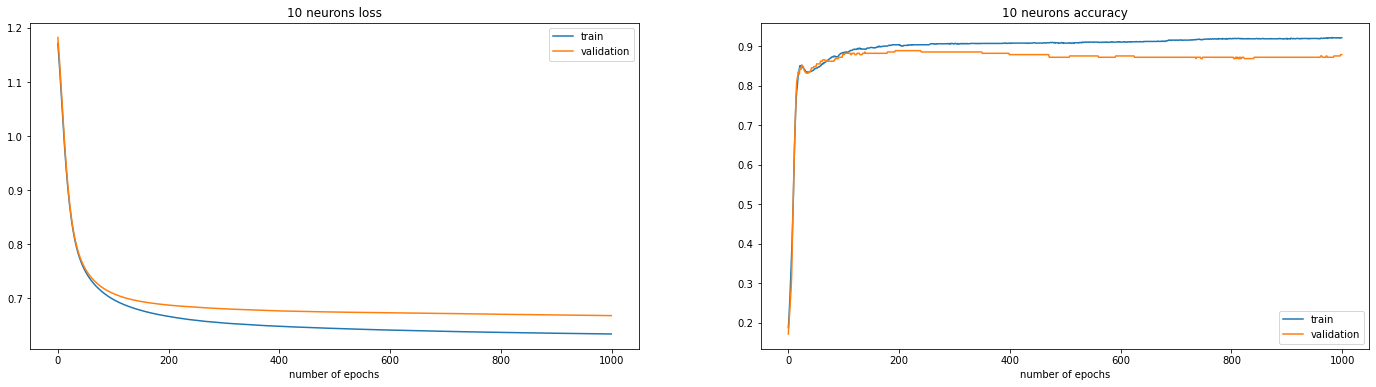

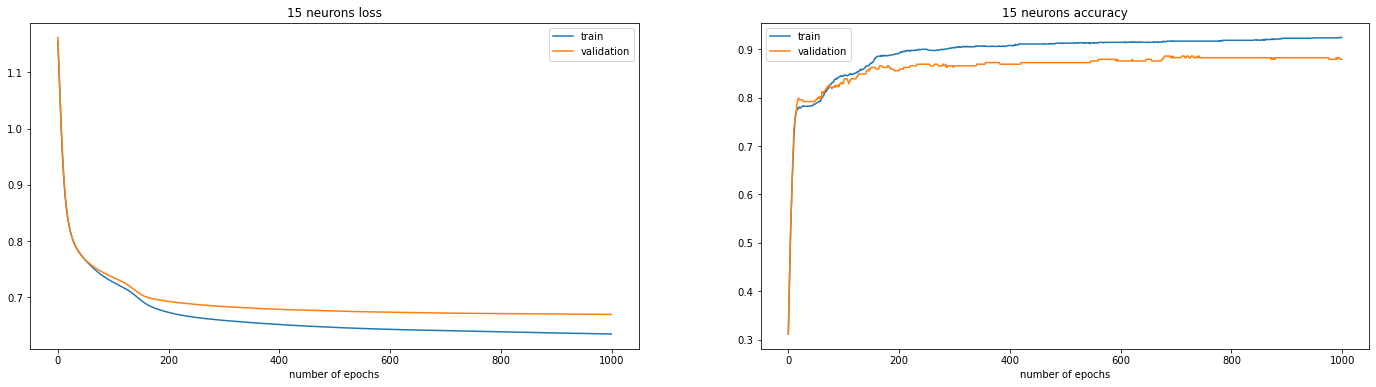

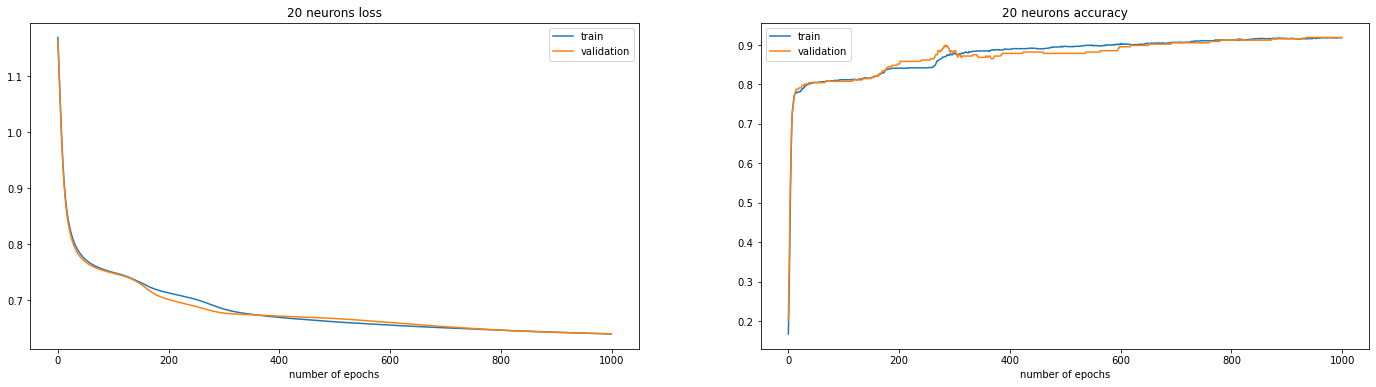

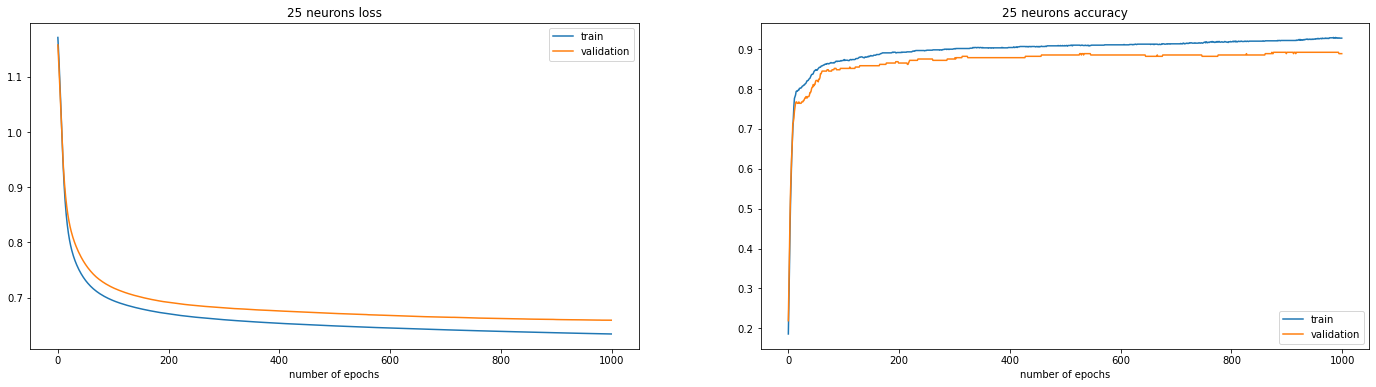

In [32]:
# plot loss and accuracy curves
for num_neurons, info in num_neurons_info.items():   
    history = info['history'].history
    _, (loss_axis, accuracy_axis) = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

    loss_axis.set_title(f'{num_neurons} neurons loss')
    
    loss_axis.plot(range(num_epochs), history['loss'], label='train')
    loss_axis.plot(range(num_epochs), history['val_loss'], label='validation')
    
    loss_axis.legend()
    loss_axis.set_xlabel('number of epochs')

    accuracy_axis.set_title(f'{num_neurons} neurons accuracy')
    
    accuracy_axis.plot(range(num_epochs), history['accuracy'], label='train')
    accuracy_axis.plot(range(num_epochs), history['val_accuracy'], label='validation')
    
    accuracy_axis.legend()
    accuracy_axis.set_xlabel('number of epochs')

plt.savefig('output/a_3a.png')
print()

b) Select the optimal number of neurons for the hidden layer. State the rationale for
your selection.

I would select 15 neurons for the hidden layer (though 10 should work too). Based on the loss curves, it seems that more neurons lead to overfitting; however, too little neurons lead to underfitting / slightly lower accuracy. 15 neurons is a good balance.

c) Plot the train and test accuracies against epochs with the optimal number of neurons.

In [33]:
optimal_num_neurons = 15

In [34]:
# train model on whole training set
model = get_3_layer_nn(optimal_num_neurons, weight_decay_parameter)

train_history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=optimal_batch_size,
    epochs=num_epochs,
    verbose=0,  # not showing training details
    validation_data=(test_features, test_labels),
    shuffle=True,
)

results = model.evaluate(
    test_features,
    test_labels,
    batch_size=optimal_batch_size,
    return_dict=True,
)

loss = results['loss']
accuracy = results['accuracy']
print(f'test loss: {loss:.2f}, test accuracy: {accuracy:.2f}')

del model

10/10 [==============================] - 0s 1ms/step - loss: 0.6717 - accuracy: 0.8824
test loss: 0.67, test accuracy: 0.88


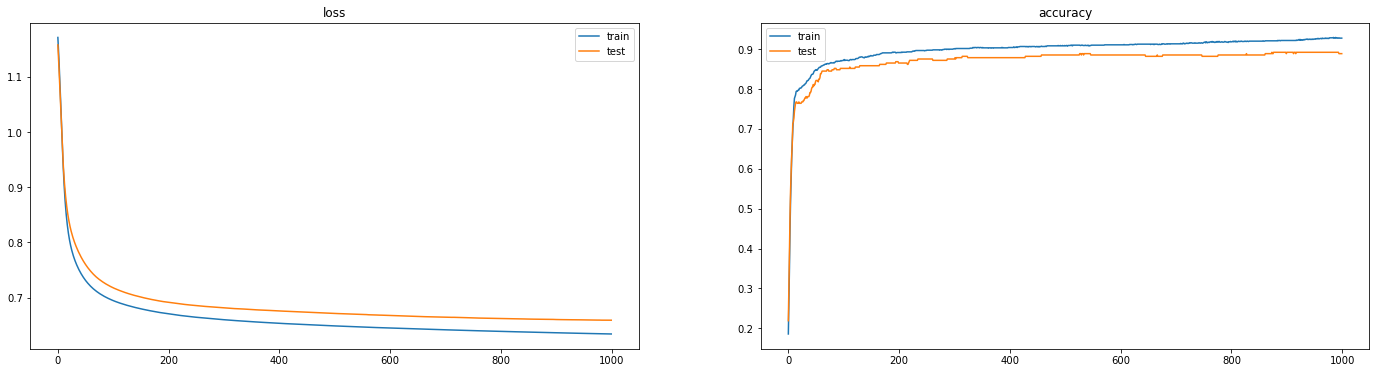

In [35]:
# plot curves
_, (loss_axis, accuracy_axis) = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

loss_axis.set_title('loss')
loss_axis.plot(range(num_epochs), history['loss'], label='train')
loss_axis.plot(range(num_epochs), history['val_loss'], label='test')
loss_axis.legend()

accuracy_axis.set_title('accuracy')
accuracy_axis.plot(range(num_epochs), history['accuracy'], label='train')
accuracy_axis.plot(range(num_epochs), history['val_accuracy'], label='test')
accuracy_axis.legend()

plt.savefig('output/a_3c.png')

del loss_axis
del accuracy_axis

4. Find the optimal decay parameter for the 3-layer network designed with optimal hidden neurons in part (3).

a) Plot cross-validation accuracies against the number of epochs for the 3-layer network for different values of decay parameters. Limit the search space of decay parameters to {0, 10<sup>-3</sup>, 10<sup>-6</sup>, 10<sup>-9</sup>, 10<sup>-12</sup>}.

In [36]:
# training params

decay_params = [0, 10**-3, 10**-6, 10**-9, 10**-12]

In [37]:
decay_params_info = {decay_param: {} for decay_param in decay_params}

for decay_param in decay_params:
    print(f'trying out decay parameter of {decay_param}')

    best_fold = 0
    best_results = {'loss': 1, 'accuracy': 0}
    best_history = None

    # 5-fold cross validation using training set
    splits = kfold.split(train_features, train_labels)
    
    for fold_index, (train_indices, val_indices) in enumerate(splits):
        print(f'working on fold {fold_index}')
        model = get_3_layer_nn(optimal_num_neurons, decay_param)

        train_features_subset = train_features.iloc[train_indices]
        train_labels_subset = train_labels.iloc[train_indices]

        val_features = train_features.iloc[val_indices]
        val_labels = train_labels.iloc[val_indices]

        train_history = model.fit(
            x=train_features_subset,
            y=train_labels_subset,
            batch_size=optimal_batch_size,
            epochs=num_epochs,
            verbose=0,  # not showing training details
            validation_data=(val_features, val_labels),
            shuffle=True,
        )

        results = model.evaluate(
            test_features,
            test_labels,
            batch_size=optimal_batch_size,
            return_dict=True,
        )

        if results['accuracy'] > best_results['accuracy']:
            best_fold = fold_index
            best_model = model
            best_results = results
            best_history = train_history

    loss = best_results['loss']
    accuracy = best_results['accuracy']
    print(f'best fold: {best_fold}, loss: {loss:.2f}, accuracy: {accuracy:.2f}')
    
    decay_params_info[decay_param]['model'] = best_model
    decay_params_info[decay_param]['results'] = results
    decay_params_info[decay_param]['history'] = best_history

trying out decay parameter of 0
working on fold 0
10/10 [==============================] - 0s 1ms/step - loss: 0.6630 - accuracy: 0.8966
working on fold 1
10/10 [==============================] - 0s 1ms/step - loss: 0.6718 - accuracy: 0.8793
working on fold 2
10/10 [==============================] - 0s 1ms/step - loss: 0.6696 - accuracy: 0.8809
working on fold 3
10/10 [==============================] - 0s 1ms/step - loss: 0.6608 - accuracy: 0.8966
working on fold 4
10/10 [==============================] - 0s 1ms/step - loss: 0.6716 - accuracy: 0.8777
best fold: 0, loss: 0.66, accuracy: 0.90
trying out decay parameter of 0.001
working on fold 0
10/10 [==============================] - 0s 1ms/step - loss: 0.6770 - accuracy: 0.8903
working on fold 1
10/10 [==============================] - 0s 1ms/step - loss: 0.6752 - accuracy: 0.8981
working on fold 2
10/10 [==============================] - 0s 1ms/step - loss: 0.6788 - accuracy: 0.8903
working on fold 3
10/10 [==========================

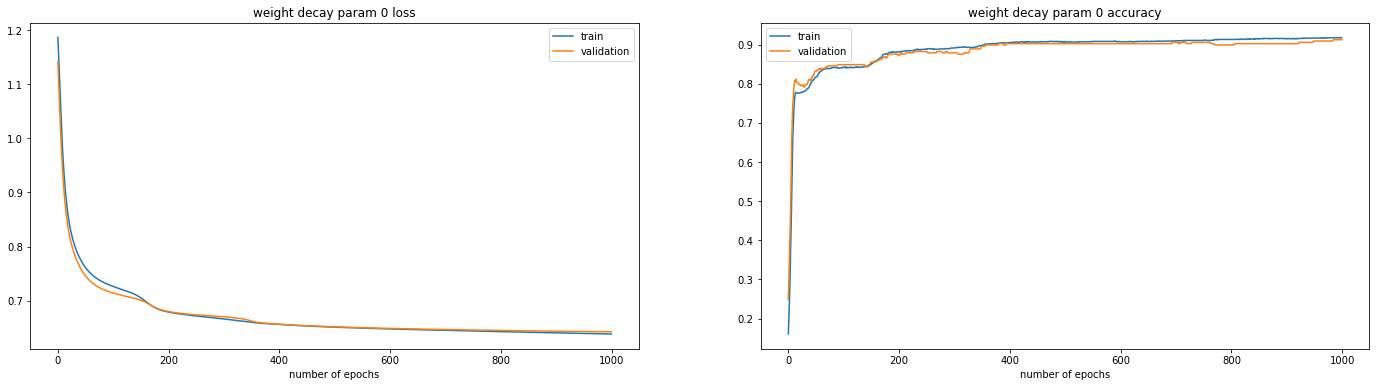

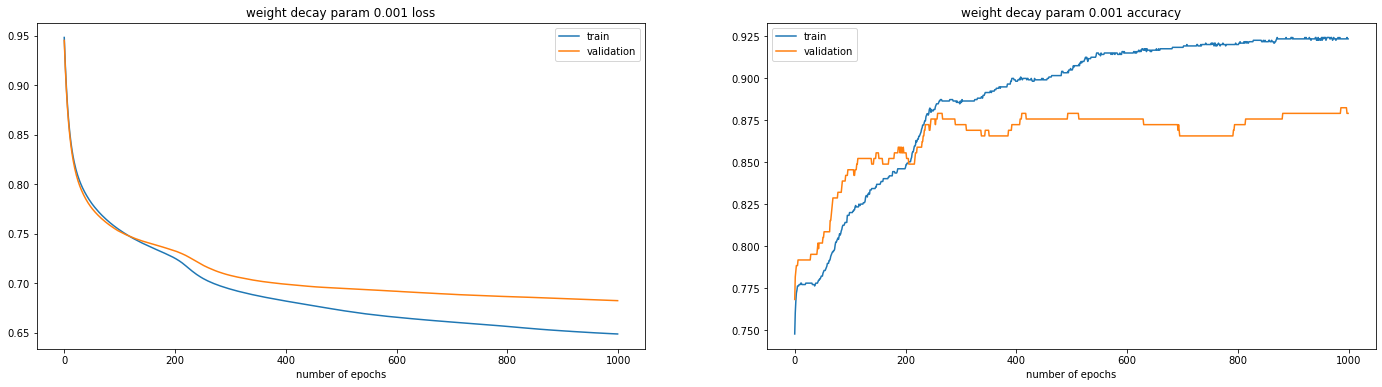

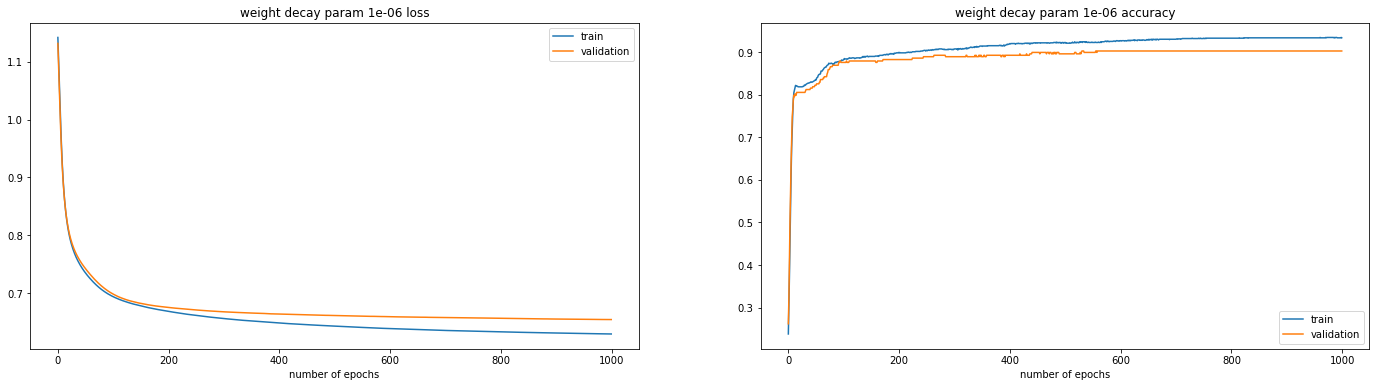

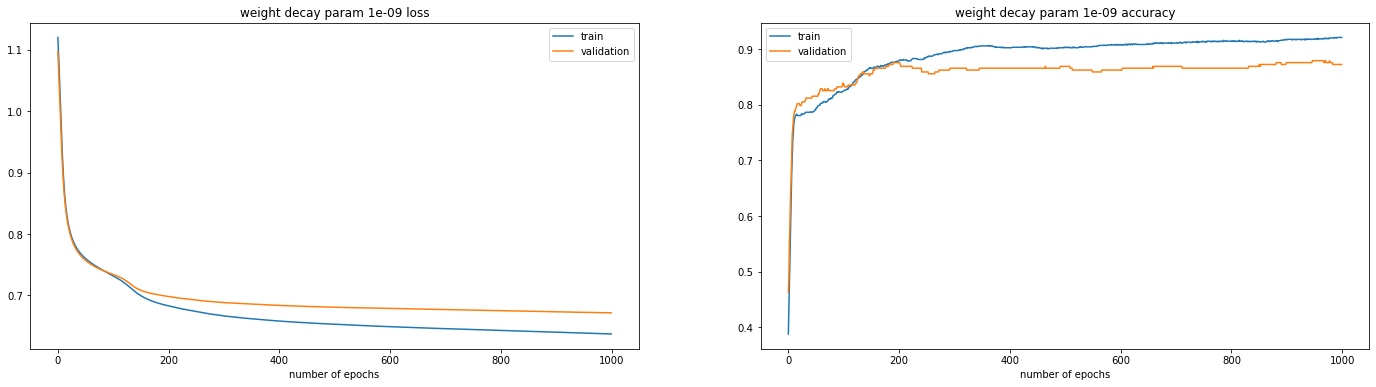

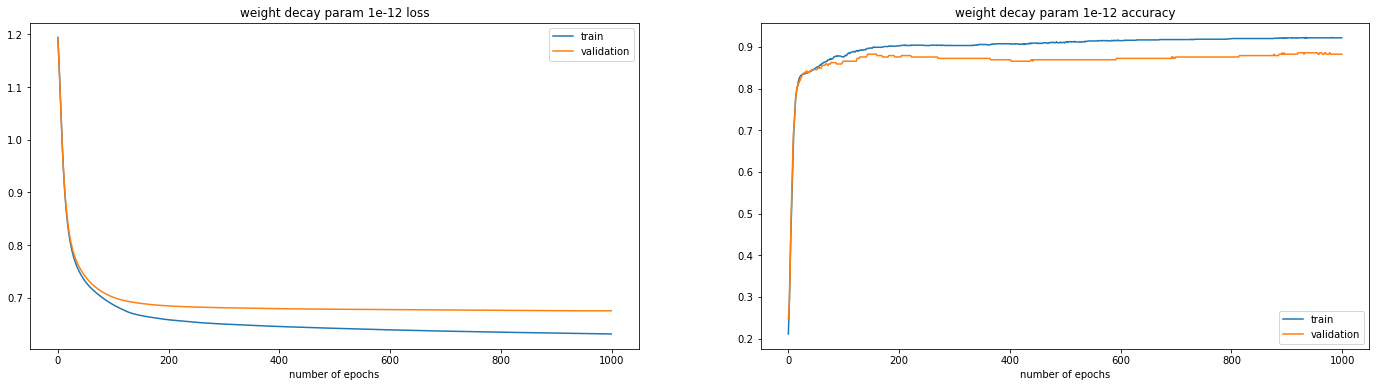

In [38]:
# plot loss and accuracy curves
for decay_param, info in decay_params_info.items():   
    history = info['history'].history
    _, (loss_axis, accuracy_axis) = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

    loss_axis.set_title(f'weight decay param {decay_param} loss')
    
    loss_axis.plot(range(num_epochs), history['loss'], label='train')
    loss_axis.plot(range(num_epochs), history['val_loss'], label='validation')
    
    loss_axis.legend()
    loss_axis.set_xlabel('number of epochs')

    accuracy_axis.set_title(f'weight decay param {decay_param} accuracy')
    
    accuracy_axis.plot(range(num_epochs), history['accuracy'], label='train')
    accuracy_axis.plot(range(num_epochs), history['val_accuracy'], label='validation')
    
    accuracy_axis.legend()
    accuracy_axis.set_xlabel('number of epochs')
    
plt.savefig('output/a_4a.png')
print()

b) Select the optimal decay parameter. State the rationale for your selection.

I do not really see any pattern based on the loss curves (e.g. larger weight decay reduces likelihood of overfitting), though the accuracy curve for 10<sup>-3</sup> looks very weird. I would go with a weight decay of 10<sup>-6</sup> (10<sup>-9</sup> and 10<sup>-12</sup> looks fine too).

c) Plot the train and test accuracies against epochs for the optimal decay parameter.

In [46]:
optimal_weight_decay = 10**-6

In [47]:
# train model on whole training set
model = get_3_layer_nn(optimal_num_neurons, optimal_weight_decay)

train_history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=optimal_batch_size,
    epochs=num_epochs,
    verbose=0,  # not showing training details
    validation_data=(test_features, test_labels),
    shuffle=True,
)

results = model.evaluate(
    test_features,
    test_labels,
    batch_size=optimal_batch_size,
    return_dict=True,
)

loss = results['loss']
accuracy = results['accuracy']
print(f'test loss: {loss:.2f}, test accuracy: {accuracy:.2f}')

del model

10/10 [==============================] - 0s 1ms/step - loss: 0.6562 - accuracy: 0.8918
test loss: 0.66, test accuracy: 0.89


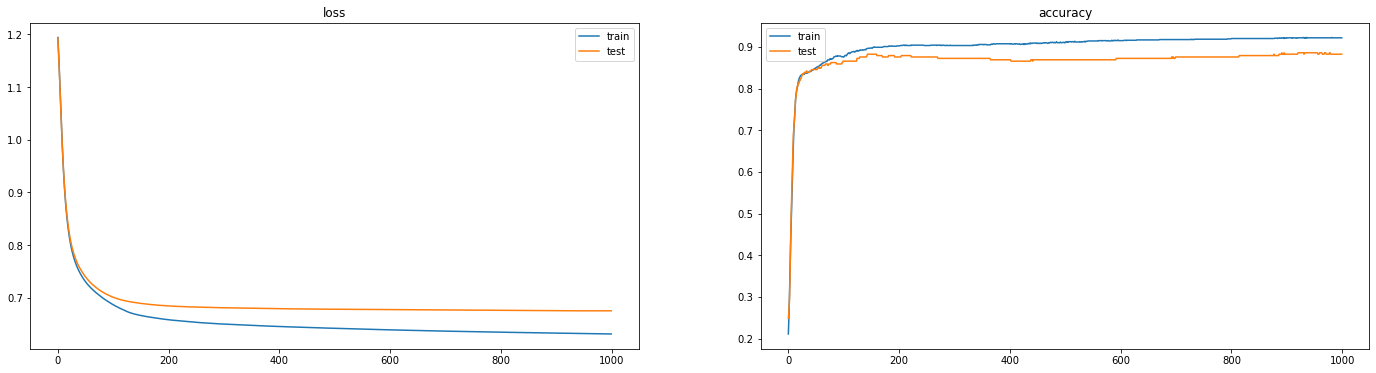

In [48]:
# plot curves
_, (loss_axis, accuracy_axis) = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

loss_axis.set_title('loss')
loss_axis.plot(range(num_epochs), history['loss'], label='train')
loss_axis.plot(range(num_epochs), history['val_loss'], label='test')
loss_axis.legend()

accuracy_axis.set_title('accuracy')
accuracy_axis.plot(range(num_epochs), history['accuracy'], label='train')
accuracy_axis.plot(range(num_epochs), history['val_accuracy'], label='test')
accuracy_axis.legend()

plt.savefig('output/a_4c.png')

del loss_axis
del accuracy_axis

5. After you are done with the 3-layer network, design a 4-layer network with two hidden-layers, each consisting 10 neurons, and train it with a batch size of 32 and decay parameter 10<sup>-6</sup>.

In [42]:
def get_4_layer_nn(num_neurons: int, decay_param: float) -> tf.keras.Sequential:
    '''
    Generates a 4-layer fully-connected neural network.
        layer 1 - input layer
        layer 2 - hidden layer
        layer 3 - hidden layer
        layer 4 - output layer (softmax)

    :params:
    - num_neurons (int): number of neurons in the hidden layer
    - decay_params (float): weight decay parameter for L_2 loss

    :return:
    - (tf.keras.Sequential)
    '''
    input_layer = tf.keras.layers.InputLayer(
        input_shape=num_features,
    )

    hidden_layer_1 = tf.keras.layers.Dense(
        num_neurons,
        activation=hidden_activation,
        kernel_regularizer=tf.keras.regularizers.l2(l=decay_param),
    )
    
    hidden_layer_2 = tf.keras.layers.Dense(
        num_neurons,
        activation=hidden_activation,
        kernel_regularizer=tf.keras.regularizers.l2(l=decay_param),
    )

    output_layer = tf.keras.layers.Dense(
        num_classes,
        activation='softmax',
    )

    model = tf.keras.Sequential([
        input_layer,
        hidden_layer_1,
        hidden_layer_2,
        output_layer,
    ])

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
        metrics=['accuracy'],
    )

    return model

In [50]:
# check model
model = get_4_layer_nn(10, 10**-6)
model.summary()

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_163 (Dense)            (None, 10)                220       
_________________________________________________________________
dense_164 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_165 (Dense)            (None, 3)                 33        
Total params: 363
Trainable params: 363
Non-trainable params: 0
_________________________________________________________________


In [51]:
# train model

tf.random.set_seed(seed)  # since shuffle=True

train_history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=32,
    epochs=num_epochs,
    verbose=0,  # not showing training details
    validation_data=(test_features, test_labels),
    shuffle=True,
)

results = model.evaluate(
    test_features,
    test_labels,
    batch_size=32,
    return_dict=True,
)

loss = results['loss']
accuracy = results['accuracy']
print(f'test loss: {loss:.2f}, test accuracy: {accuracy:.2f}')

del model

20/20 [==============================] - 0s 1ms/step - loss: 0.6559 - accuracy: 0.8966
test loss: 0.66, test accuracy: 0.90


a) Plot the train and test accuracy of the 4-layer network.

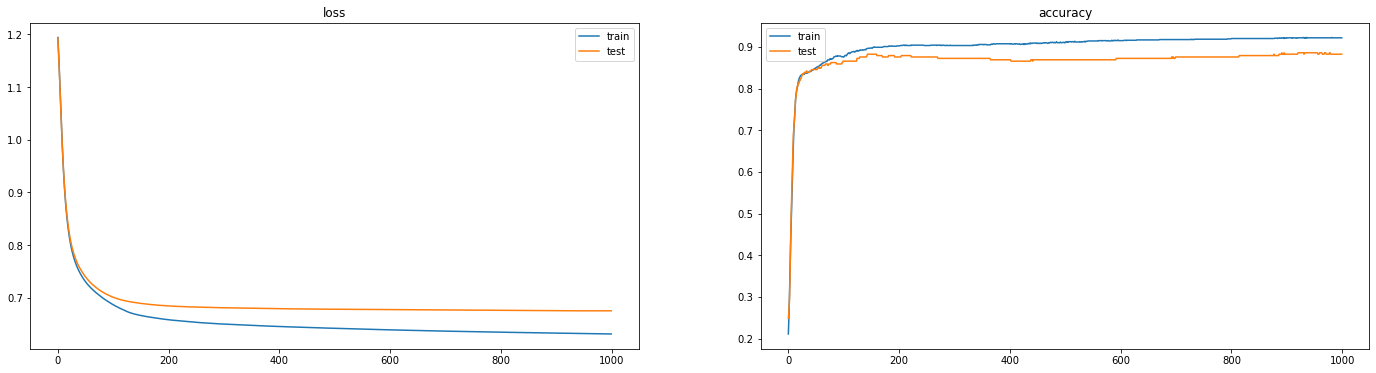

In [52]:
# plot curves

_, (loss_axis, accuracy_axis) = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

loss_axis.set_title('loss')
loss_axis.plot(range(num_epochs), history['loss'], label='train')
loss_axis.plot(range(num_epochs), history['val_loss'], label='test')
loss_axis.legend()

accuracy_axis.set_title('accuracy')
accuracy_axis.plot(range(num_epochs), history['accuracy'], label='train')
accuracy_axis.plot(range(num_epochs), history['val_accuracy'], label='test')
accuracy_axis.legend()

plt.savefig('output/a_5a.png')

del loss_axis
del accuracy_axis

b) Compare and comment on the performances of the optimal 3-layer and 4-layer networks.

The 4-layer network is as good as, if not better than, the 3-layer network without even being tuned. The additional layer probably allowed the 4-layer network to learn another set of features in the data, leading to better accuracy.